In [ ]:
!pip install transformers datasets evaluate
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 118 kB 35.7 MB/s 


In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import io
import os
import re
import matplotlib.pyplot as plt### plotting bar chart
import string
import evaluate
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import create_optimizer,T5TokenizerFast,DataCollatorForSeq2Seq,TFT5ForConditionalGeneration,TFAutoModelForSeq2SeqLM,AutoModelForSeq2SeqLM,TFT5ForConditionalGeneration

In [ ]:
BATCH_SIZE=64
MAX_LENGTH=128

# Data Preparation

In [ ]:
#dataset_id="liweili/c4_200m"
dataset_id="leslyarun/c4_200m_gec_train100k_test25k"

In [ ]:
dataset = load_dataset(dataset_id)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/leslyarun___csv/leslyarun--c4_200m_gec_train100k_test25k-97a9e10d1a9b0a0d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 25000
    })
})

In [ ]:
dataset['train'][0]

{'input': 'Bitcoin is for $7,094 this morning, which CoinDesk says.',
 'output': 'Bitcoin goes for $7,094 this morning, according to CoinDesk.'}

In [ ]:
model_id="t5-small"
tokenizer=T5TokenizerFast.from_pretrained(model_id)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
def preprocess_function(examples):

  inputs = [example for example in examples['input']]
  targets = [example for example in examples['output']]

  model_inputs = tokenizer(inputs, text_target=targets,max_length=MAX_LENGTH, truncation=True)
  return model_inputs

In [ ]:
tokenized_dataset=dataset.map(preprocess_function,batched=True,remove_columns=dataset["train"].column_names)

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25000
    })
})

In [ ]:
tokenized_dataset['train'][1000]

{'input_ids': [6844, 3, 18, 3, 26, 51, 226, 3, 14198, 169, 53, 39, 1339, 5, 1],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [6844, 3, 26, 51, 226, 3, 14198, 3, 18, 150, 1339, 831, 5, 1]}

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model, return_tensors="tf")

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
train_dataset=tokenized_dataset["train"].to_tf_dataset(
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
val_dataset=tokenized_dataset["test"].to_tf_dataset(
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [ ]:
for i in val_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[ 9139,   138,  2253, ...,     0,     0,     0],
       [ 9627,    37,  5791, ...,     0,     0,     0],
       [  116,    27,  4839, ...,     0,     0,     0],
       ...,
       [20255,  3535,     2, ...,     0,     0,     0],
       [10846,   670,    11, ...,     0,     0,     0],
       [ 1541,   132,    19, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 98), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(64, 99), dtype=int64, numpy=
array([[   37, 13477,  2253, ...,  -100,  -100,  -100],
       [ 9627,    37,  5791, ...,  -100,  -100,  -100],
       [    3,    99,    27, ...,  -100,  -100,  -100],
       ...,
       [20255,  3535,     2, ...,  -100,  -100,  -100],
       [10846,   670

# Modeling

In [ ]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (TFSharedEmbeddings)  multiple                 16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  18881280  
                                                                 
 decoder (TFT5MainLayer)     multiple                  25175808  
                                                                 
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
num_epochs = 5
num_train_steps=len(train_dataset)*num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=num_epochs
)

Epoch 1/5
1563/1563 [==============================] - 1650s 1s/step - loss: 0.9188 - val_loss: 0.7687
Epoch 2/5
1563/1563 [==============================] - 1637s 1s/step - loss: 0.8288 - val_loss: 0.7377
Epoch 3/5
1563/1563 [==============================] - 1646s 1s/step - loss: 0.8052 - val_loss: 0.7261
Epoch 4/5
1563/1563 [==============================] - 1639s 1s/step - loss: 0.7941 - val_loss: 0.7214
Epoch 5/5
1563/1563 [==============================] - 1640s 1s/step - loss: 0.7878 - val_loss: 0.7198


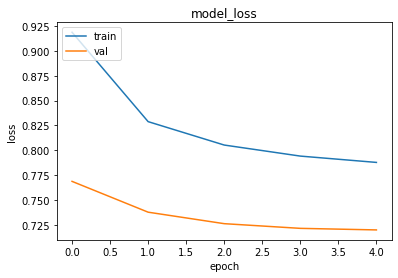

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/nlp/gec/t5-small.h5')

# Evaluation

In [ ]:
metric = evaluate.load("sacrebleu")

In [ ]:
all_preds = []
all_labels = []
    
for batch in val_dataset.take(5):
  predictions = model.generate(
      input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
  )
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = batch["labels"].numpy()
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  all_preds.extend(decoded_preds)
  all_labels.extend(decoded_labels)

result = metric.compute(predictions=all_preds, references=all_labels)
print(result)

{'score': 27.081681255317868, 'counts': [3548, 2739, 2162, 1706], 'totals': [4157, 3837, 3517, 3197], 'precisions': [85.35001202790474, 71.38389366692729, 61.47284617571794, 53.362527369408824], 'bp': 0.40503703885753123, 'sys_len': 4157, 'ref_len': 7914}


In [ ]:
decoded_preds

['The evening will also include a series of readings about a poet’s life and',
 'How long has been working at the Museum?',
 'Share price of Tesla Motors, Inc. plummeted 1.6% to $219.',
 'Recycle and scrap metal centers will pay top dollar for anything you bring in from a full',
 '5. In InfoClick, use the menu DataBase> Scan For New Emails',
 'TT: How much more money do you need these maintenance projects?',
 'Bancari Romani and RCS Sport are pleased to announce the partnership with Brooks US',
 'Works on both offshore and onshore seismic data.',
 'In the gable in the main building is the intoning white triangle for “water',
 'Don’t be shy with the pepper,y or want to feel the heat and the full',
 'Timely essay written by Carl Freitag two years ago.',
 'The finding is included in one of two official reports into allegations of a plot to take control',
 'To be used to build additional tools on top of.',
 '11 + Then shall the /(Coma) children of Judah and',
 'Meets Snell 2010 and DOT cer

In [ ]:
decoded_labels

['The evening will also feature a series of readings about the poet’s life and work by former and current poet laureates of Peterborough; Keely Mills, Pete Cox, Charley Genever and Toby Wood.',
 'How long have you been working at the Museum?',
 'Share price of Tesla Motors, Inc. plummeted 1.6% to $219.07 on Jul 8, after a trademark infringement charge was leveled against the automaker by businessman Zhan Baosheng in China.',
 'Recycle and scrap metal centers will pay you top dollar for anything you bring in, from a bag full of soda cans to your old water heater, you can expect to get some dough for your old junk.',
 '5. In InfoClick use the menu Database > Scan For New Emails. Once InfoClick has finished scanning for new emails, make sure the copied files are complete and the search results are as you expect.',
 'TT: How much more money do you need for those maintenance projects?',
 'Bancari Romani and RCS Sport are pleased to announce the partnership with Brooks. The US sports brand h

# Testing


In [ ]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city"
    ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='tf'
)
out = model.generate(**tokenized, max_length=128)
print(out)

tf.Tensor(
[[    0 12919    63     3 18261    31    15   342    53   160  2418     5
      1     0     0     0     0]
 [    0  6920 11342  4188  9491  1054 13055 28442   235   346    88    60
      5     1     0     0     0]
 [    0     3    23   261    12   114  5989     5     1     0     0     0
      0     0     0     0     0]
 [    0  2087    62   225  7958     3     9  1338    28     8   151    45
      8   245  3523     5     1]
 [    0   116    33    62   352    12   456  1556  3370    58     1     0
      0     0     0     0     0]
 [    0   186   648  3412  1590    16    82   690     5     1     0     0
      0     0     0     0     0]], shape=(6, 17), dtype=int32)


In [ ]:
for i in range(len(wrong_english)):
  print(wrong_english[i]+"------------>"+tokenizer.decode(out[i], skip_special_tokens=True))

Dady hav'e eateing her foot------------>Dady hav'eateing her foot.
DJ Sorryyouwastedyourmoneytobehere------------>DJ Sorryyouwastedyourmoneytobehere.
i used to like to swimming------------>i used to like swimming.
maybe we should organized a meetin with the people from unesco------------>maybe we should organize a meeting with the people from the unesco.
when are we goinge to start play football------------>when are we going to start playing football?
many a time rain fall in my city------------>many times rain fall in my city.


# Testing on Pretrained Model (No FineTuning)

In [ ]:
pretrained_model=AutoModelForSeq2SeqLM.from_pretrained(
    "juancavallotti/t5-base-gec"
)

In [ ]:
wrong_english=[
    "Dady hav'e eateing her foot",
    "DJ Sorryyouwastedyourmoneytobehere",
    "i used to like to swimming",
    "maybe we should organized a meetin with the people from unesco",
    "when are we goinge to start play football",
    "many a time rain fall in my city",
   ]
tokenized=tokenizer(
  wrong_english,
  padding="longest",
  max_length=MAX_LENGTH,
  truncation=True,
  return_tensors='pt'
)
out=pretrained_model.generate(**tokenized, max_length=128)
print(out)

tensor([[    0, 12919,    63,     3,   342,   160,  2418,     3,     5,     1,
             0,     0,     0,     0,     0,     0,     0],
        [    0,  6920, 11342,     6,    25, 21133,    39,   540,     3,     6,
             1,     0,     0,     0,     0,     0,     0],
        [    0,    27,   261,    12,   114,  5989,     3,     5,     1,     0,
             0,     0,     0,     0,     0,     0,     0],
        [    0,  3836,    62,   225,  7958,     3,     9,  1338,    28,     8,
           151,    45,   245,  3523,     3,     5,     1],
        [    0,   366,    33,    62,   352,    12,   456,  1556,  3370,     1,
             0,     0,     0,     0,     0,     0,     0],
        [    0,  1404,     3,     9,    97,  3412,  7250,    16,    82,   690,
             1,     0,     0,     0,     0,     0,     0]])


In [ ]:
for i in range(len(wrong_english)):
  print(wrong_english[i]+"------------>"+tokenizer.decode(out[i], skip_special_tokens=True))

Dady hav'e eateing her foot------------>Dady ate her foot.
DJ Sorryyouwastedyourmoneytobehere------------>DJ Sorry, you wasted your money,
i used to like to swimming------------>I used to like swimming.
maybe we should organized a meetin with the people from unesco------------>Maybe we should organize a meeting with the people from unesco.
when are we goinge to start play football------------>When are we going to start playing football
many a time rain fall in my city------------>Many a time rain falls in my city


# Deprecated Code

## Data Download

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d a0155991rliwei/c4-200m
!unzip "/content/c4-200m.zip" -d "/content/dataset/"

100% 19.3G/19.3G [02:43<00:00, 81.6MB/s]
100% 19.3G/19.3G [02:44<00:00, 126MB/s] 
Archive:  /content/c4-200m.zip
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00000-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00001-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00002-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00003-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00004-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00005-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00006-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00007-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00008-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00009-of-00512  
  inflating: /content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00

## Data Preparation

In [ ]:
max_source_length = 128
max_target_length = 128

In [ ]:
raw_dataset = tf.data.TFRecordDataset('/content/dataset/c4200m/1.0.0/c4200m-train.tfrecord-00001-of-00512')

In [ ]:
for raw_record in raw_dataset.take(2):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xc6\x01\nb\n\x06output\x12X\nV\nTOur courses are free to schools who are members of ICT SLA 1 \xe2\x80\x93 curriculum support.\n`\n\x05input\x12W\nU\nSOur courses are highly free schools to members of ICT SLA 1 \xe2\x80\x93 curriculum support.'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xdd\x01\nh\n\x05input\x12_\n]\n[Udder costs kip60,000. while a pregnant uterus will set you back Kip30,000 or about 4,70 $.\nq\n\x06output\x12g\ne\ncUdder costs Kip60,000 while a pregnant uterus will set you back Kip30,000 or about AUD$4.70 per kg.'>


In [ ]:
# Create a description of the features.
feature_description = {
    
    'input': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'output': tf.io.FixedLenFeature([], tf.string, default_value=''),
}
def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [ ]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset element_spec={'input': TensorSpec(shape=(), dtype=tf.string, name=None), 'output': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [ ]:
for parsed_record in parsed_dataset.take(1):
    #print(repr(parsed_record))
    pass
print(parsed_record['input'].numpy())
print(parsed_record['output'].numpy())


b'Our courses are highly free schools to members of ICT SLA 1 \xe2\x80\x93 curriculum support.'
b'Our courses are free to schools who are members of ICT SLA 1 \xe2\x80\x93 curriculum support.'


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
len(tokenizer.get_vocab())

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


32100

In [ ]:
inp_list=[]
for parsed_record in parsed_dataset:
  inp_list.append([parsed_record['input'].numpy().decode("utf-8"),parsed_record['output'].numpy().decode("utf-8")])

In [ ]:
len(inp_list)

359168

In [ ]:
header = ['input','attention_mask','output']

with open('c4_200_00001.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
      
    encoding = tokenizer(
      list(np.array(inp_list)[:,0]),
      padding="longest",
      max_length=max_source_length,
      truncation=True,
    )

    target_encoding = tokenizer(
      list(np.array(inp_list)[:,1]),
      padding="longest",
      max_length=max_source_length,
      truncation=True,
    )
    final_list=[[encoding.input_ids[i],encoding.attention_mask[i],target_encoding.input_ids[i]] for i in range(len(encoding.input_ids))]
    writer.writerows(final_list)

In [ ]:
!cp /content/c4_200_00001.csv /content/drive/MyDrive/gec_dataset

In [ ]:
data= pd.read_csv("/content/drive/MyDrive/gec_dataset/c4_200_00000.csv")

In [ ]:

print(data['input'][1001])
print(len(list(map(int,data['input'][100][1:-1].split(", ")))))
print(list(map(int,data['input'][100][1:-1].split(", "))))
print(list(map(int,data['attention_mask'][100][1:-1].split(", "))))
print(list(map(int,data['output'][100][1:-1].split(", "))))

[31118, 3, 18, 23535, 21, 82, 384, 11, 3, 9, 385, 7029, 140, 21, 21, 128, 161, 1576, 16, 207, 97, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
128
[19204, 3, 390, 30, 48, 794, 130, 5163, 11, 8107, 120, 29329, 11, 985, 13, 135, 808, 2656, 20295, 298, 8, 119, 985, 808, 4621, 5819, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
len(data)

359169

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,data,batch_size,):
        self.batch_size=batch_size
        self.data=data
        
    def __len__(self):
        return len(self.data)//self.batch_size

    def __getitem__(self,idx):
        x,y=self.data_generation(idx)
        return x,y

    def data_generation(self,idx):

      x_1=[]
      x_2=[]
      y=[]

      for j in range(idx*self.batch_size,(idx+1)*self.batch_size):
          x_1.append(list(map(int,data['input'][j][1:-1].split(", "))))
          x_2.append(list(map(int,data['attention_mask'][j][1:-1].split(", "))))
          y.append(list(map(int,data['output'][j][1:-1].split(", "))))

      input_ids=np.array(x_1)
      attention_mask=np.array(x_2)
      decoder_input_ids=np.array(tf.concat([tf.zeros([self.batch_size,1],dtype=tf.int32),np.array(y)[:,0:-1]],axis=-1))
      labels=np.array(y)

      return [input_ids,attention_mask,decoder_input_ids],labels

In [ ]:
BATCH_SIZE=16
train_gen=DataGenerator(data,BATCH_SIZE,)
#val_gen=DataGenerator(val_images,BATCH_SIZE,tokenizer,data_dict,starttoken,INPUT_DIM)

## Modeling

In [ ]:
model = TFT5ForConditionalGeneration.from_pretrained("t5-base")
model.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (TFSharedEmbeddings)  multiple                 24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  84954240  
                                                                 
 decoder (TFT5MainLayer)     multiple                  113275008 
                                                                 
Total params: 222,903,552
Trainable params: 222,903,552
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #run_eagerly=True,
)
model.fit(train_gen,epochs=1)

22448/22448 [==============================] - 21295s 946ms/step - loss: 0.1806


In [ ]:
model.load_weights('/content/drive/MyDrive/gec_dataset/t5-base-00000-gec.h5')

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
#wrong_english=["i thought you come yesterday to come collect the cars?","do you really want to saw me go.",
wrong_english=["Dady hav'e eateing her foot",
               "DJ Sorryyouwastedyourmoneytobehere",
               "i used to like to swimming",
               "maybe we should organized a meetin with the people from unesco",
               "when are we goinge to start play football",
               "many a time rain fall in my city"]
encoding = tokenizer(
      wrong_english,#list(np.array(inp_list)[:,0]),
      padding="longest",
      max_length=max_source_length,
      truncation=True,

    )

In [ ]:
outputs=model.generate(np.array(encoding['input_ids']))

for i in range(len(wrong_english)):
  print(wrong_english[i]+"------------>"+tokenizer.decode(outputs[i], skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/generation_tf_utils.py:1576: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Dady hav'e eateing her foot------------>Dady ate her foot.
DJ Sorryyouwastedyourmoneytobehere------------>DJ Sorryyouwastedyourmoneytobehere.
i used to like to swimming------------>i used to like swimming.
maybe we should organized a meetin with the people from unesco------------>maybe we should organize a meeting with the people from unesco.
when are we goinge to start play football------------>when are we going to start playing football?
many a time rain fall in my city------------>many a time rain fall in my city.


In [ ]:
# from transformers import T5Tokenizer, TFT5ForConditionalGeneration

# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

# model.summary()
# # the following 2 hyperparameters are task-specific
# max_source_length = 64
# max_target_length = 64

# # Suppose we have the following 2 training examples:
# input_sequence_1 = "i really loves mangoes."
# output_sequence_1 = "i really love mangoes."

# input_sequence_2 = "whenever you saw me, run?"
# output_sequence_2 = "whenever you see me, run!"

# # encode the inputs
# input_sequences = [input_sequence_1,input_sequence_2]

# encoding = tokenizer(
#     [input_sequence_1,input_sequence_2],

#     padding="longest",
#     max_length=max_source_length,a
#     truncation=True,
#     return_tensors="tf",

#     )

# input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
# print('input_ids',input_ids)
# print(attention_mask)
# # encode the targets
# target_encoding = tokenizer(
#     [output_sequence_1,output_sequence_2],
#     padding="longest",
#     max_length=max_source_length,
#     truncation=True,
#     return_tensors="tf",
#     )
# labels = target_encoding.input_ids
# print('labels',labels)

In [ ]:
# from transformers import T5Tokenizer, TFT5ForConditionalGeneration

# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

# model.summary()
# # the following 2 hyperparameters are task-specific
# max_source_length = 64
# max_target_length = 64

# # Suppose we have the following 2 training examples:
# input_sequence_1 = "i really loves mangoes."
# output_sequence_1 = "i really love mangoes."

# input_sequence_2 = "whenever you saw me, run?"
# output_sequence_2 = "whenever you see me, run!"

# # encode the inputs
# input_sequences = [input_sequence_1,input_sequence_2]

# encoding = tokenizer(
#     [input_sequence_1,input_sequence_2],

#     padding="longest",
#     max_length=max_source_length,a
#     truncation=True,
#     return_tensors="tf",

#     )

# input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
# print('input_ids',input_ids)
# print(attention_mask)
# # encode the targets
# target_encoding = tokenizer(
#     [output_sequence_1,output_sequence_2],
#     padding="longest",
#     max_length=max_source_length,
#     truncation=True,
#     return_tensors="tf",
#     )
# labels = target_encoding.input_ids
# print('labels',labels)